# Dataset

In [118]:
! pip install torch
! pip install imageio
! pip install ipywidgets


In [119]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import tensorflow as tf
tf.config.optimizer.set_jit(False)  # disable XLA


In [195]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

In [196]:
dataset.shape

(20, 10000, 64, 64)

In [197]:
# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:2000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

In [198]:
dataset.shape

(2000, 20, 64, 64, 1)

In [199]:
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [200]:
train_dataset.shape

(1800, 20, 64, 64, 1)

In [201]:
val_dataset.shape

(200, 20, 64, 64, 1)

In [202]:


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (1800, 19, 64, 64, 1), (1800, 19, 64, 64, 1)
Validation Dataset Shapes: (200, 19, 64, 64, 1), (200, 19, 64, 64, 1)


Displaying frames for example 214.


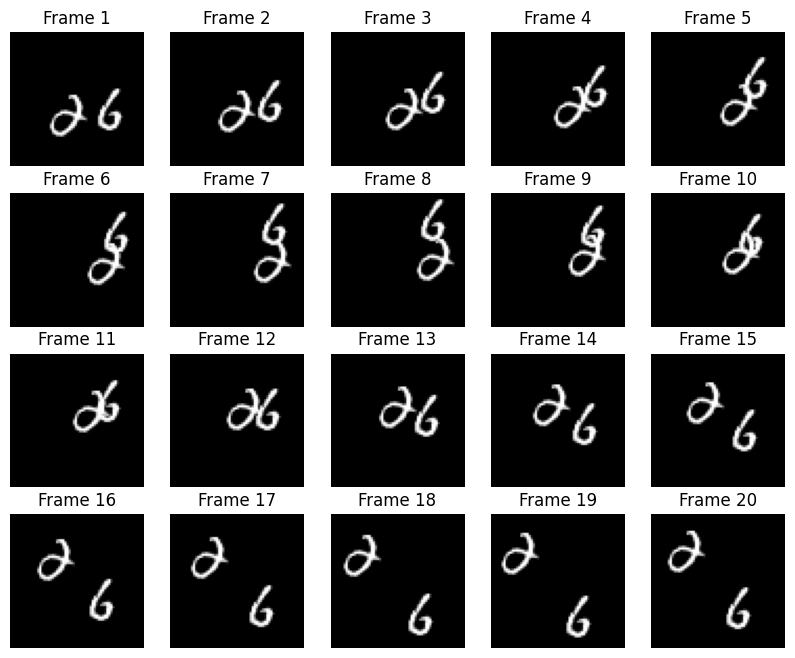

In [203]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

# Logger

In [204]:
import logging
import json
import os
from tensorflow.keras.callbacks import Callback
import numpy as np

class JSONMetricsLogger(Callback):
    def __init__(self, log_name="model"):
        super().__init__()
        os.makedirs("logs", exist_ok=True)
        self.log_path = os.path.join("logs", f"{log_name}_metrics.json")

        self.logger = logging.getLogger(f"{log_name}_logger")
        self.logger.setLevel(logging.INFO)
        self.logger.handlers.clear()

        handler = logging.FileHandler(self.log_path, mode="w")
        formatter = logging.Formatter('%(message)s')
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)

    def on_epoch_end(self, epoch, logs=None):
        if logs:
            cleaned_logs = {
                k: float(v) if isinstance(v, (np.floating, float, int)) else str(v)
                for k, v in logs.items()
            }
            cleaned_logs['epoch'] = epoch + 1
            self.logger.info(json.dumps(cleaned_logs))


# ConvLSTM

In [207]:
from tensorflow.keras import Sequential, layers, optimizers, losses

convlstm_model = Sequential([
    layers.Input(shape=(None, 64, 64, 1)),  # [B, T, H, W, C]

    layers.ConvLSTM2D(64, (5, 5), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(64, (1, 1), padding='same', return_sequences=True, activation='relu'),

    layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')
])



In [208]:
convlstm_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)


In [209]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
json_logger = JSONMetricsLogger(log_name="convlstm")

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
convlstm_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, json_logger],
)

Epoch 1/20


2025-06-28 19:34:29.990537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/sequential_23/conv_lstm2d_45/while/sequential_23/conv_lstm2d_45/while_grad/body/_555/input/_1530' -> 'gradient_tape/sequential_23/conv_lstm2d_45/while/sequential_23/conv_lstm2d_45/while_grad/body/_555/gradient_tape/sequential_23/conv_lstm2d_45/while/gradients/AddN', 'Func/gradient_tape/sequential_23/conv_lstm2d_44/while/sequential_23/conv_lstm2d_44/while_grad/body/_750/input/_1649' -> 'gradient_tape/sequential_23/conv_lstm2d_44/while/sequential_23/conv_lstm2d_44/while_grad/body/_750/gradient_tape/sequential_23/conv_lstm2d_44/while/gradients/AddN', 'Func/gradient_tape/sequential_23/conv_lstm2d_43/while/sequential_23/conv_lstm2d_43/while_grad/body/_945/input/_1765' -> 'gradient_tape/sequential_23/conv_lstm2d_43/while/sequential_23/conv_lstm2d_43/while_grad/body/_945/gra

360/360 [==============================] - 54s 142ms/step - loss: 0.0550 - binary_accuracy: 0.9276 - val_loss: 0.1893 - val_binary_accuracy: 0.9298 - lr: 0.0010
Epoch 2/20
360/360 [==============================] - 50s 140ms/step - loss: 0.0266 - binary_accuracy: 0.9315 - val_loss: 0.0319 - val_binary_accuracy: 0.9314 - lr: 0.0010
Epoch 3/20
360/360 [==============================] - 51s 140ms/step - loss: 0.0258 - binary_accuracy: 0.9315 - val_loss: 0.0255 - val_binary_accuracy: 0.9311 - lr: 0.0010
Epoch 4/20
360/360 [==============================] - 50s 140ms/step - loss: 0.0253 - binary_accuracy: 0.9315 - val_loss: 0.0254 - val_binary_accuracy: 0.9311 - lr: 0.0010
Epoch 5/20
360/360 [==============================] - 50s 140ms/step - loss: 0.0250 - binary_accuracy: 0.9315 - val_loss: 0.0253 - val_binary_accuracy: 0.9313 - lr: 0.0010
Epoch 6/20
360/360 [==============================] - 50s 140ms/step - loss: 0.0248 - binary_accuracy: 0.9315 - val_loss: 0.0250 - val_binary_accuracy:

In [241]:
convlstm_model.save("convlstm_model.keras")

In [ ]:
from tensorflow import keras

convlstm_model = keras.models.load_model("convlstm_model.keras")

1/1 [==============================] - 0s 59ms/step


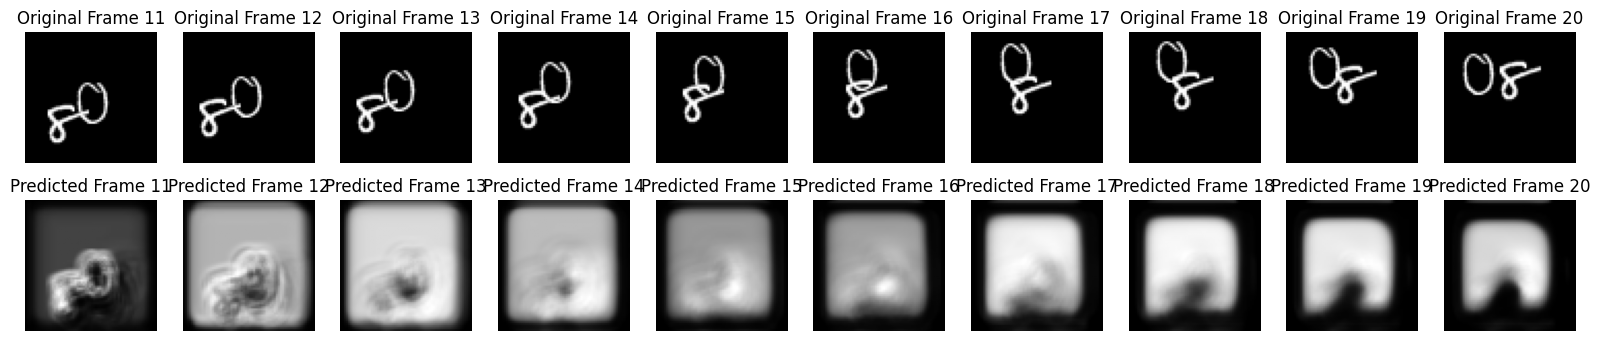

In [213]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = convlstm_model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Original Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Predicted Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

# ConvNCP: Spatial * 3 + 1 Temporal

In [214]:
from tensorflow.keras import Sequential, layers, optimizers, losses
from ncps.tf import LTC
from ncps.wirings import AutoNCP

convncp_model = Sequential([
    layers.Input(shape=(None, 64, 64, 1)),

    # Encoder (same filters as ConvLSTM)
    layers.TimeDistributed(layers.Conv2D(64, (5, 5), padding='same', activation='relu')),
    layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu')),
    layers.TimeDistributed(layers.Conv2D(64, (1, 1), padding='same', activation='relu')),

    # Flatten spatial dimensions
    layers.TimeDistributed(layers.Flatten()),
    layers.TimeDistributed(layers.Dense(64)),  # Project to LTC input size

    # Temporal core: NCP with 64 output neurons (matching ConvLSTM filters)
    LTC(AutoNCP(units=96, output_size=64), return_sequences=True),

    # Decoder: vector → frame
    layers.TimeDistributed(layers.Dense(64 * 64, activation='relu')),
    layers.TimeDistributed(layers.Reshape((64, 64, 1))),

    # Temporal frame stack → 3D conv to smooth spatiotemporal output
    layers.Reshape((-1, 64, 64, 1)),  # [B, T, H, W, 1]
    layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')
])

convncp_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)


In [215]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
json_logger = JSONMetricsLogger(log_name="convncp")

convncp_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, json_logger],
)


Epoch 1/20
360/360 [==============================] - 37s 91ms/step - loss: 0.6198 - binary_accuracy: 0.9196 - val_loss: 0.5527 - val_binary_accuracy: 0.9298 - lr: 0.0010
Epoch 2/20
360/360 [==============================] - 32s 88ms/step - loss: 0.4996 - binary_accuracy: 0.9289 - val_loss: 0.4506 - val_binary_accuracy: 0.9298 - lr: 0.0010
Epoch 3/20
360/360 [==============================] - 31s 85ms/step - loss: 0.4128 - binary_accuracy: 0.9289 - val_loss: 0.3771 - val_binary_accuracy: 0.9298 - lr: 0.0010
Epoch 4/20
360/360 [==============================] - 31s 87ms/step - loss: 0.2455 - binary_accuracy: 0.9289 - val_loss: 0.1764 - val_binary_accuracy: 0.9298 - lr: 0.0010
Epoch 5/20
360/360 [==============================] - 31s 87ms/step - loss: 0.1768 - binary_accuracy: 0.9289 - val_loss: 0.1721 - val_binary_accuracy: 0.9298 - lr: 0.0010
Epoch 6/20
360/360 [==============================] - 32s 89ms/step - loss: 0.1738 - binary_accuracy: 0.9289 - val_loss: 0.1709 - val_binary_accu

In [240]:
convncp_model.save("convncp_model.keras")


In [ ]:
from tensorflow import keras

convncp_model = keras.models.load_model("convncp_model.keras")


1/1 [==============================] - 0s 43ms/step


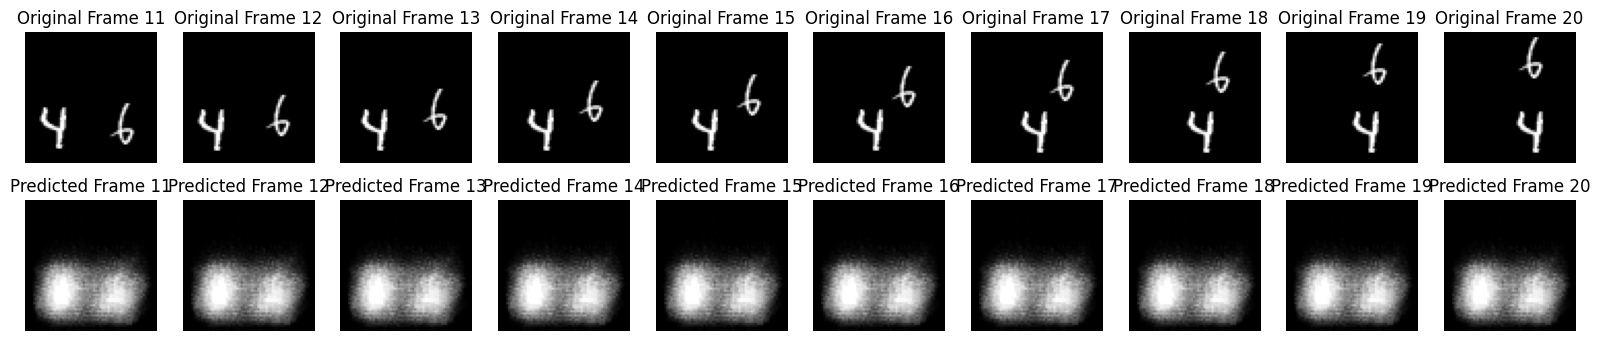

In [210]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = convncp_model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Original Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Predicted Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

1/1 [==============================] - 0s 35ms/step


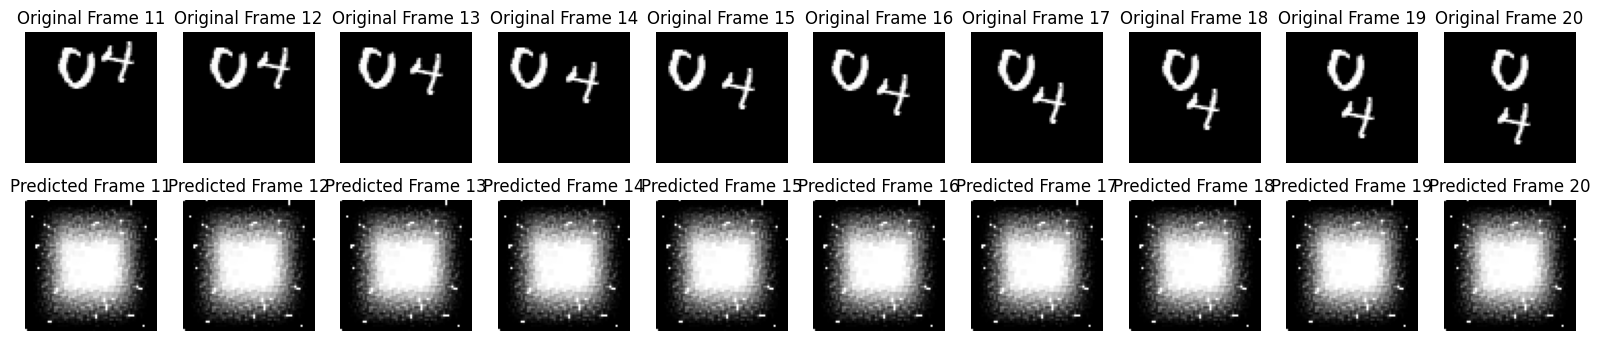

In [217]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = convncp_model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Original Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Predicted Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

# ConvNCP: Interleaved spatial + temporal

In [221]:
from tensorflow.keras import Sequential, layers
from ncps.tf import LTC
from ncps.wirings import AutoNCP

convncp_model2 = Sequential([
    layers.Input(shape=(None, 64, 64, 1)),

    # 🔁 Interleaved Block 1
    layers.TimeDistributed(layers.Conv2D(64, (5, 5), padding='same', activation='relu')),
    layers.TimeDistributed(layers.Flatten()),
    layers.TimeDistributed(layers.Dense(64)),
    LTC(AutoNCP(units=96, output_size=64), return_sequences=True),

    # 🔁 Interleaved Block 2
    layers.TimeDistributed(layers.Dense(64 * 64, activation='relu')),      # NCP → 2D
    layers.TimeDistributed(layers.Reshape((64, 64, 1))),
    layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu')),
    layers.TimeDistributed(layers.Flatten()),
    layers.TimeDistributed(layers.Dense(64)),
    LTC(AutoNCP(units=96, output_size=64), return_sequences=True),

    # 🔁 Interleaved Block 3
    layers.TimeDistributed(layers.Dense(64 * 64, activation='relu')),
    layers.TimeDistributed(layers.Reshape((64, 64, 1))),
    layers.TimeDistributed(layers.Conv2D(64, (1, 1), padding='same', activation='relu')),
    layers.TimeDistributed(layers.Flatten()),
    layers.TimeDistributed(layers.Dense(64)),
    LTC(AutoNCP(units=96, output_size=64), return_sequences=True),

    # 🔁 Decoder
    layers.TimeDistributed(layers.Dense(64 * 64, activation='relu')),
    layers.TimeDistributed(layers.Reshape((64, 64, 1))),
    layers.Reshape((-1, 64, 64, 1)),
    layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')
])


In [223]:
convncp_model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)


In [224]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
json_logger = JSONMetricsLogger(log_name="convncp2")

convncp_model2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, json_logger],
)


Epoch 1/20
360/360 [==============================] - 93s 233ms/step - loss: 0.2344 - binary_accuracy: 0.9021 - val_loss: 0.1742 - val_binary_accuracy: 0.9295 - lr: 0.0010
Epoch 2/20
360/360 [==============================] - 81s 224ms/step - loss: 0.1736 - binary_accuracy: 0.9288 - val_loss: 0.1693 - val_binary_accuracy: 0.9298 - lr: 0.0010
Epoch 3/20
360/360 [==============================] - 84s 232ms/step - loss: 0.1708 - binary_accuracy: 0.9289 - val_loss: 0.1673 - val_binary_accuracy: 0.9298 - lr: 0.0010
Epoch 4/20
360/360 [==============================] - 83s 230ms/step - loss: 0.1693 - binary_accuracy: 0.9289 - val_loss: 0.1666 - val_binary_accuracy: 0.9298 - lr: 0.0010
Epoch 5/20
360/360 [==============================] - 84s 232ms/step - loss: 0.1685 - binary_accuracy: 0.9289 - val_loss: 0.1655 - val_binary_accuracy: 0.9298 - lr: 0.0010
Epoch 6/20
360/360 [==============================] - 81s 224ms/step - loss: 0.1679 - binary_accuracy: 0.9289 - val_loss: 0.1655 - val_binar

In [235]:
convncp_model2.save("convncp_model2.keras")

## Don't know how reload NCP network

In [ ]:
from tensorflow import keras
model = keras.models.load_model("convncp_model2.keras", custom_objects={
    "LTC": LTC,
    "AutoNCP": AutoNCP
})



OSError: No file or directory found at /logs/convncp_model2.keras

1/1 [==============================] - 0s 98ms/step


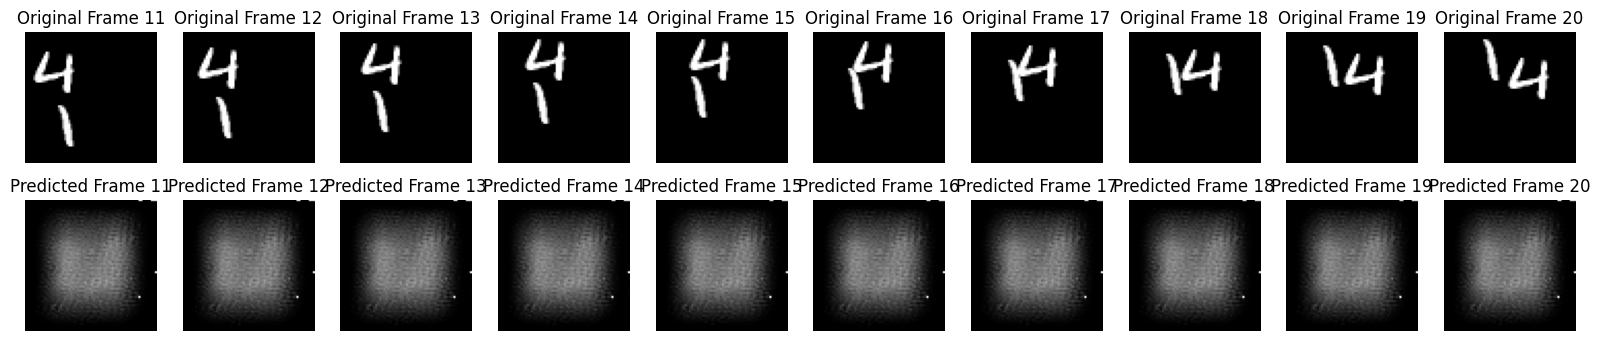

In [227]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = convncp_model2.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Original Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Predicted Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

# Plotting

In [228]:
import pandas as pd
import matplotlib.pyplot as plt

# Load logs
lstm_df = pd.read_json("logs/convlstm_metrics.json", lines=True)
ncp_df = pd.read_json("logs/convncp_metrics.json", lines=True)
ncp2_df = pd.read_json("logs/convncp2_metrics.json", lines=True)

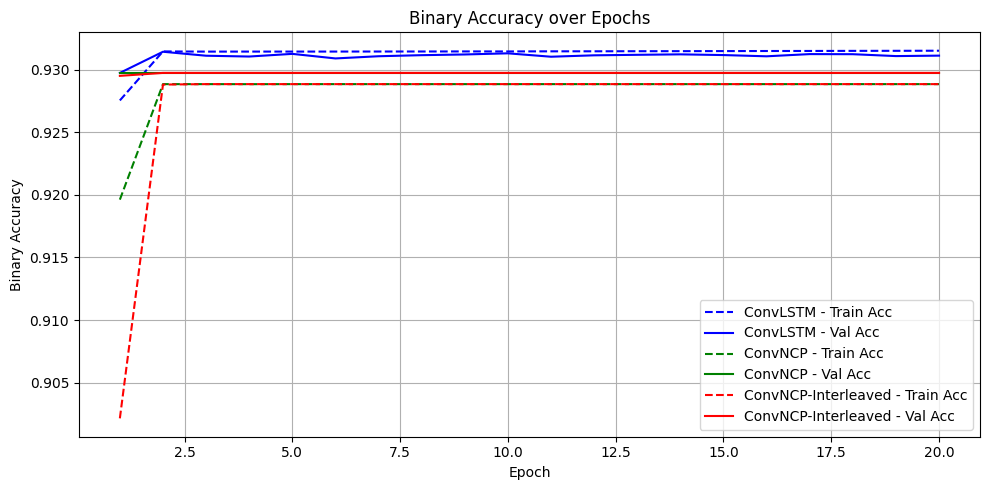

In [230]:
# Plot binary accuracy
plt.figure(figsize=(10, 5))
plt.plot(lstm_df['epoch'], lstm_df['binary_accuracy'], label='ConvLSTM - Train Acc', color='blue',
    linestyle='dashed')
plt.plot(lstm_df['epoch'], lstm_df['val_binary_accuracy'], label='ConvLSTM - Val Acc', color='blue',
    linestyle='solid')
plt.plot(ncp_df['epoch'], ncp_df['binary_accuracy'], label='ConvNCP - Train Acc', color='green',
    linestyle='dashed')
plt.plot(ncp_df['epoch'], ncp_df['val_binary_accuracy'], label='ConvNCP - Val Acc', color='green',
    linestyle='solid')
plt.plot(ncp2_df['epoch'], ncp2_df['binary_accuracy'], label='ConvNCP-Interleaved - Train Acc', color='red',
    linestyle='dashed')
plt.plot(ncp2_df['epoch'], ncp2_df['val_binary_accuracy'], label='ConvNCP-Interleaved - Val Acc', color='red',
    linestyle='solid')

plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.title('Binary Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


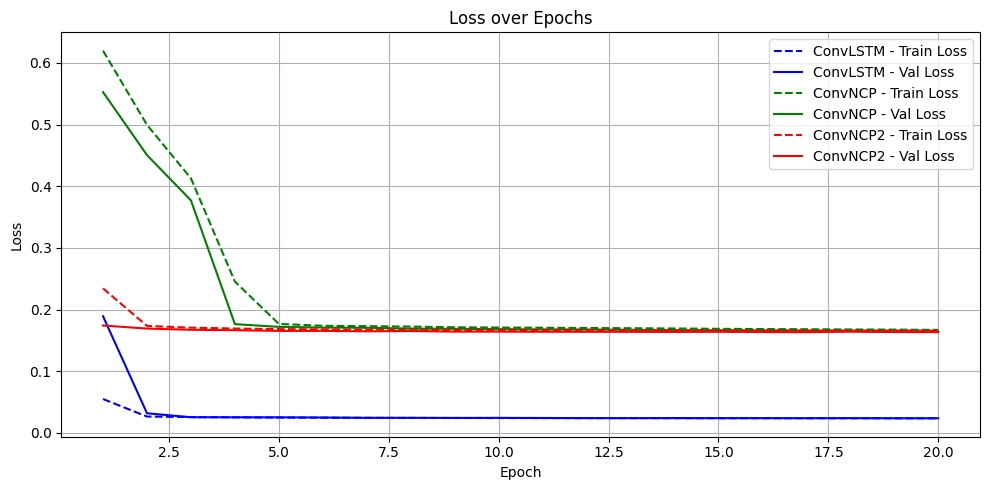

In [231]:
plt.figure(figsize=(10, 5))
plt.plot(lstm_df['epoch'], lstm_df['loss'], label='ConvLSTM - Train Loss', color='blue',
    linestyle='dashed')
plt.plot(lstm_df['epoch'], lstm_df['val_loss'], label='ConvLSTM - Val Loss', color='blue',
    linestyle='solid')
plt.plot(ncp_df['epoch'], ncp_df['loss'], label='ConvNCP - Train Loss', color='green',
    linestyle='dashed')
plt.plot(ncp_df['epoch'], ncp_df['val_loss'], label='ConvNCP - Val Loss', color='green',
    linestyle='solid')
plt.plot(ncp2_df['epoch'], ncp2_df['loss'], label='ConvNCP2 - Train Loss', color='red',
    linestyle='dashed')
plt.plot(ncp2_df['epoch'], ncp2_df['val_loss'], label='ConvNCP2 - Val Loss', color='red',
    linestyle='solid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
